# Домашнее задание 5. Градиентный спуск. (10 баллов + 2 балла бонус)

В этом домашнем задании вы реализуете градиентный спуск для линейной регрессии, а также изучите, как он ведёт себя при разных параметрах и с разными функциями потерь.

Правила:

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания всем участникам нарушения будет выставлено 0 баллов, независимо от того, кто у кого списывал.

* Старайтесь сделать код максимально оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, рассмотренных в курсе.  

In [483]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — **Mean Squared Error (MSE)**:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов.

Чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его **не нужно**. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса.
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять градиент функции потерь по параметрам модели.

In [6]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число - значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`.

Он должен вычислять лосс и градиент по формулам наверху.

In [210]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return 1 / len(X) * np.sum((np.sum(X*w, axis=1) - y) ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return 2 / len(X) * np.sum(np.transpose(X) * np.array(np.sum(X*w, axis=1) - y), axis=1)

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [213]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^{t+1} = w^{t} - \eta \nabla_{w} Q(w^{t}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`.

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше, и возвращать
траекторию спуска (список из новых значений весов на каждом шаге).

In [241]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int --сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """
    sp = [w_init]
    for i in range(n_iterations):
        sp.append(sp[-1]-lr*loss.calc_grad(X, y, sp[-1]))
    return sp
    

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории.

In [244]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] # разные масштабы признаков
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [246]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045026
0.8670644395649493


In [248]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # Отображение уровня функции потерь
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # Отображение траектории спуска
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте четыре и более различных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска.

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`.
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1.

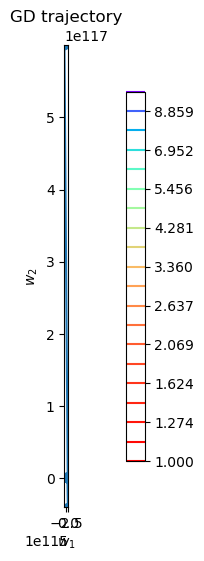

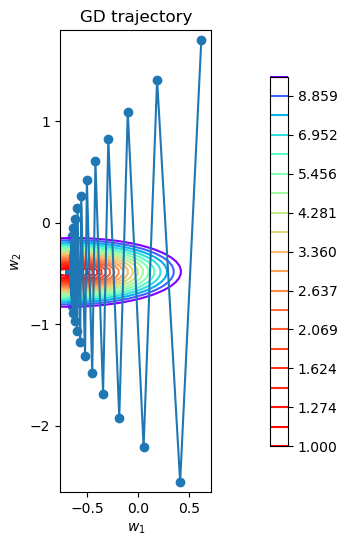

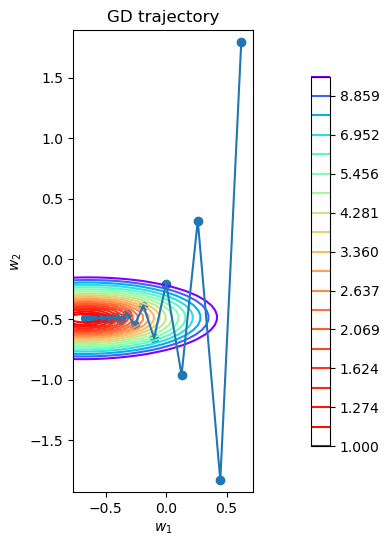

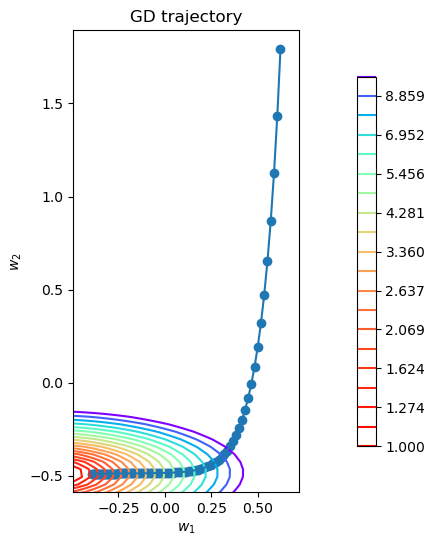

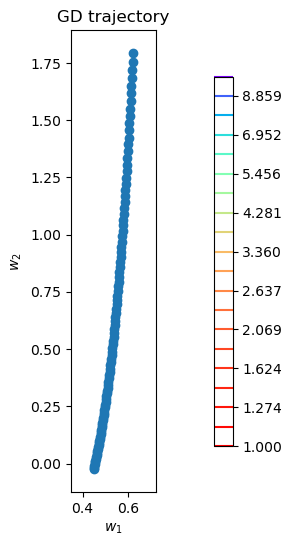

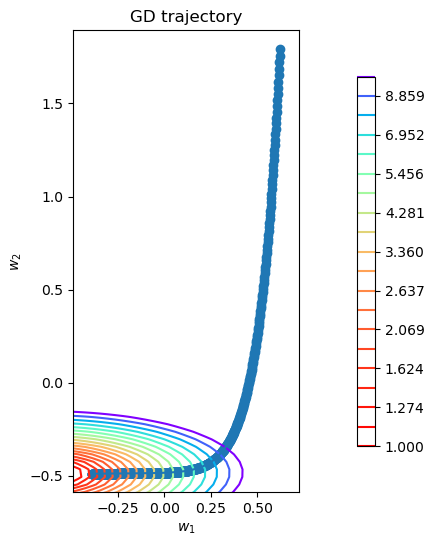

In [298]:
w_list = gradient_descent(w_init, X, y, loss, 0.1, 100)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.012, 100)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.001, 100)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.0001, 100)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.0001, 1000)
plot_gd(w_list, X, y, loss)

Как мы видим, при слишком больших значениях lr, градиентный спуск перепрыгивает минимум и расходится, что видно, когда lr - 0.1. Более наглядно эти прыжки видно при lr = 0.012, точки то сверху, то снизу. Когда lr = 0.01 и 0.001, то веса успевают дойти до минимума, а вот график при 0.0001 похож на 0.001, но шаг настолько маленький, что просто не успевает дойти до оптимальных значений, если увеличить количество итераций, то успевает. Ну и вывод - нужно методом тыка искать такие значения, что не слишком долго (то есть не слишком маленькое), но и чтобы не расходилось (слишком большое). 

Теперь реализуем стохастический градиентный спуск.

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`.

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [377]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    sp = [w_init]
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        ybatch = y[batch_indices]
        sp.append(sp[-1]-lr*loss.calc_grad(batch, ybatch, sp[-1]))
    return sp
    

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного? Что происходит при малых и больших `batch_size`?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

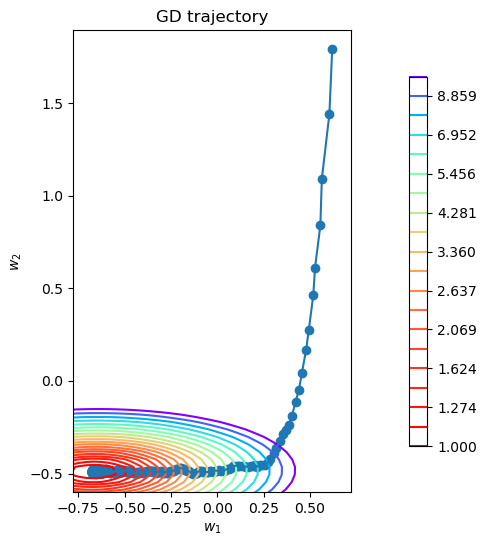

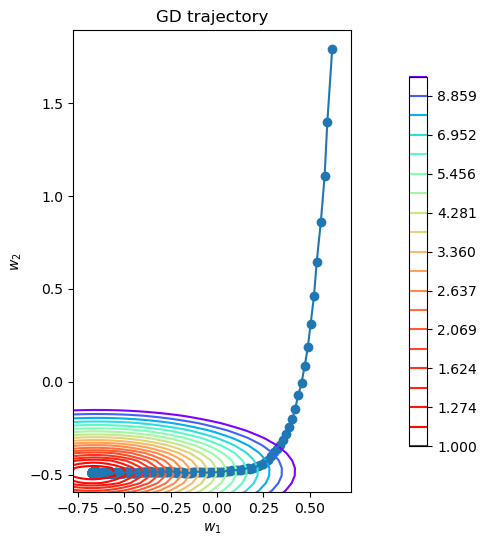

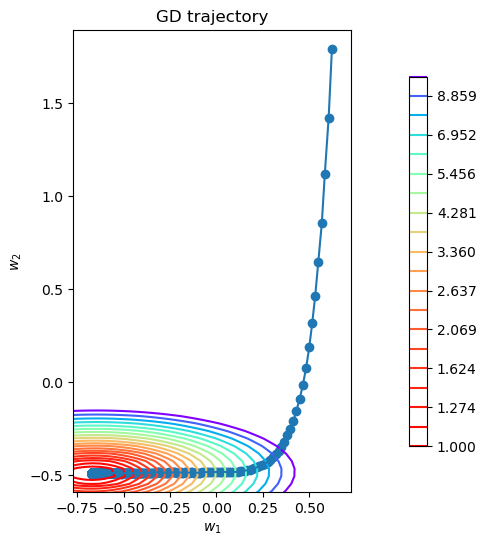

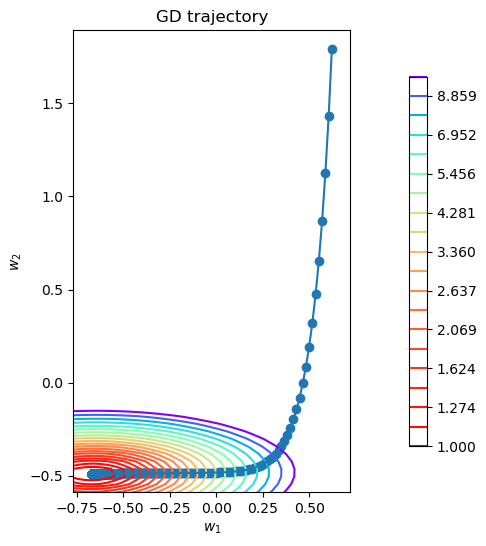

In [394]:
# -- YOUR CODE HERE -- ٩(⁎❛ᴗ❛⁎)۶
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 50, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 150, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 250, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 300, 1000)
plot_gd(w_list, X, y, loss)

Первым делом я проверил, а как влияет batch_size при конкретном lr, как мы видим, практически никак, первый график немного колбасит в начале, но в общем то картина одна и та же. Так же нужно сказать, что batch_size = 300 это обычный градиентный спуск, так как batch_size = len(X)

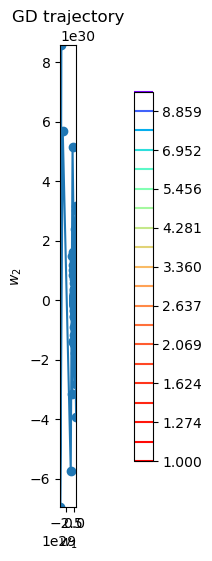

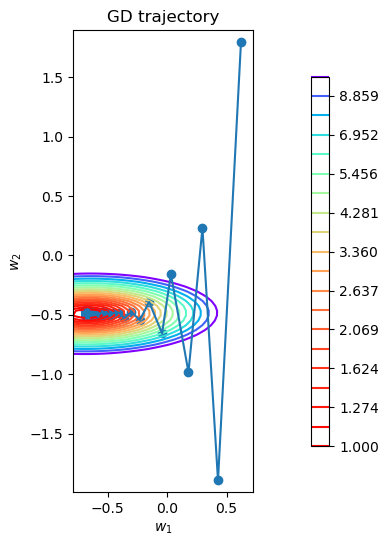

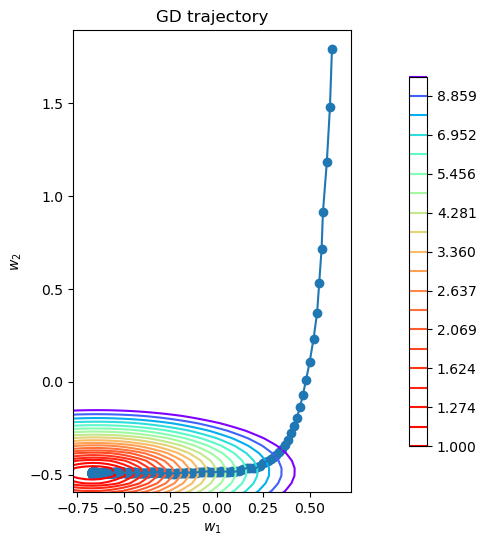

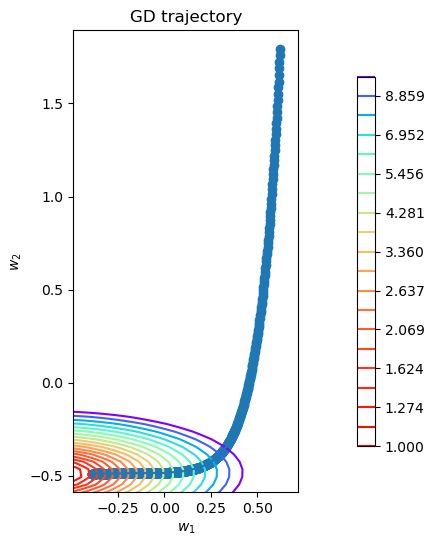

In [407]:
# -- YOUR CODE HERE -- ٩(⁎❛ᴗ❛⁎)۶
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.013, 150, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 150, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 150, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.0001, 150, 1000)
plot_gd(w_list, X, y, loss)

При lr = 0.1 у меня вообще все сломалось, потому что значения сначала ушли в бесконечность, а потом nan. В остальном функции очень похожи, но стоит отметить, что я поставил количество шагов 1000 а не 100, вссе таки стохастический делает шаги более мелкие чем обычный спуск

C:\Users\1\AppData\Local\Temp\ipykernel_784\1894922101.py:26: RuntimeWarning: invalid value encountered in subtract
  sp.append(sp[-1]-lr*loss.calc_grad(batch, ybatch, sp[-1]))


[array([0.62074297, 1.79288146]), array([ -1.34526143, -33.96113941]), array([-25.04621622, 472.94806781]), array([   91.45105867, -6808.27397136]), array([-1838.33551488, 98013.07779424]), array([   26984.14963569, -1477317.10415219]), array([  299526.83256092, 23228839.70286762]), array([ 2.04493629e+06, -3.25207032e+08]), array([-3.04472803e+07,  4.84536657e+09]), array([ 2.60315745e+08, -6.92177878e+10]), array([1.64863956e+10, 1.12153857e+12]), array([-1.00899847e+11, -1.72550478e+13]), array([-4.35148591e+12,  2.73877461e+14]), array([ 5.39860248e+13, -3.84614807e+15]), array([-1.19185969e+15,  5.72850738e+16]), array([ 1.25791401e+16, -8.28972259e+17]), array([2.95979483e+16, 1.24616239e+19]), array([ 3.22459627e+18, -1.80002915e+20]), array([5.02961618e+19, 2.46666074e+21]), array([ 8.53824545e+20, -3.49326627e+22]), array([-8.87871706e+21,  5.37858564e+23]), array([ 9.57612657e+22, -7.97244894e+24]), array([-4.75279168e+24,  1.16358825e+26]), array([ 3.60891271e+25, -1.8338065

ValueError: Axis limits cannot be NaN or Inf

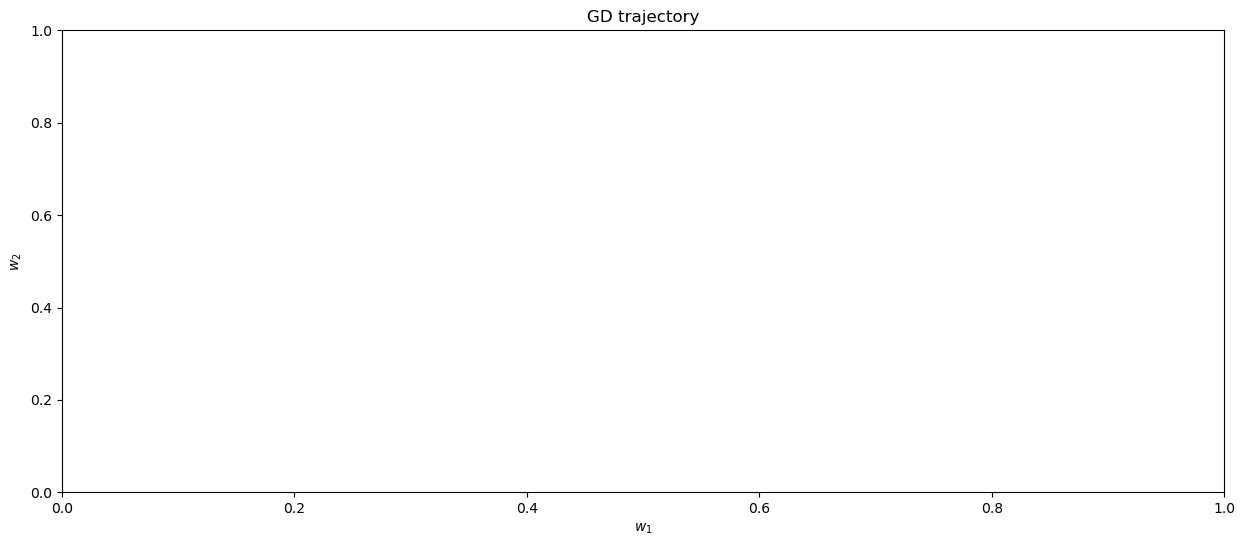

In [414]:
#вот собственно и десонстрация lr = 0.1
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.1, 150, 1000)
print(w_list)
plot_gd(w_list, X, y, loss)


Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы точнее этого минимума достигнуть и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [418]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float - параметр величины шага, на который нужно домножать градиент
    :param batch_size: int - размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float - значение степени в формуле затухания длины шага
    :param n_iterations: int - сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """
    sp = [w_init]
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        ybatch = y[batch_indices]
        sp.append(sp[-1]-lr*((1/(1 + i))**p)*loss.calc_grad(batch, ybatch, sp[-1]))
    return sp

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска. Что происходит при маленьком или большом значении p?

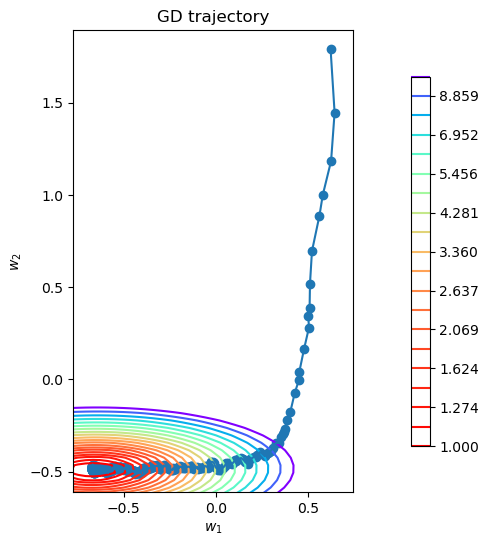

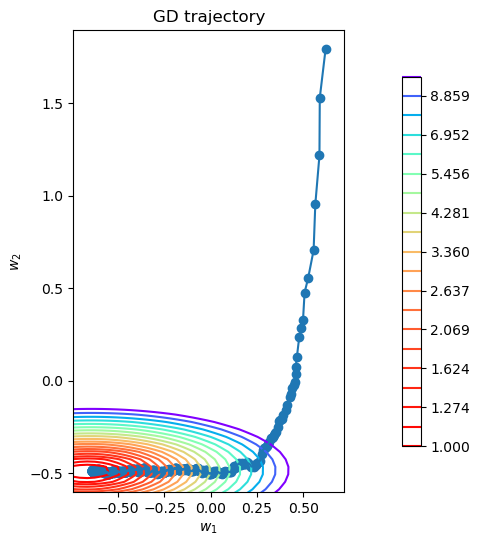

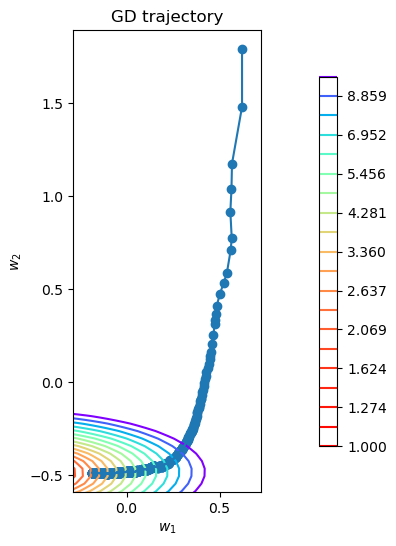

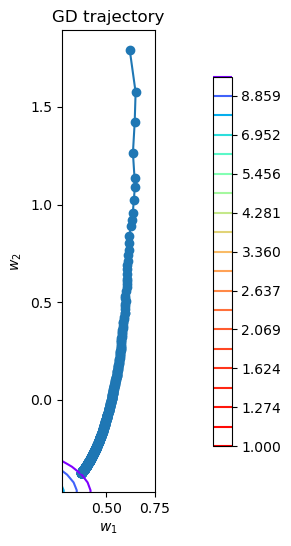

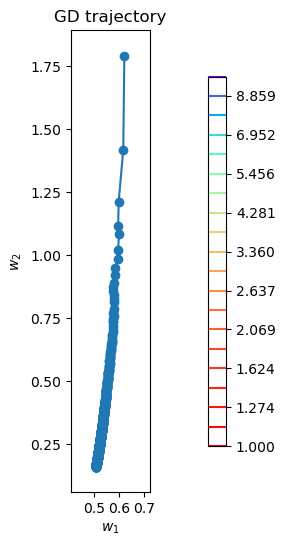

In [422]:
# -- YOUR CODE HERE -- ٩(⁎❛ᴗ❛⁎)۶
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 0.1, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 0.25, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 0.5, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 0.75, 1000)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 1, 1000)
plot_gd(w_list, X, y, loss)

При p -> 0 это обычный стохастический градиентный спуск, так как все что угодно в степени 0 - это 1, а lr * 1 = lr. Само выражение-множитель, которое является правильной дробью от 0 до 1, поэтому при возведении его в степень p очень большой оно будет стремиться к 0, так как чем больше степень, тем меньше выражение, поэтому на первых же шагах длина шага будет очень сильно уменьшаться. На графиках мы это и видим - при 0.1, 0.25 все хорошо, 0.5 тоже, но уже не доходит до центра, при 0.75 еле-еле успевает дойти до крайней окружности, при 1 вообще застрял спуск

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

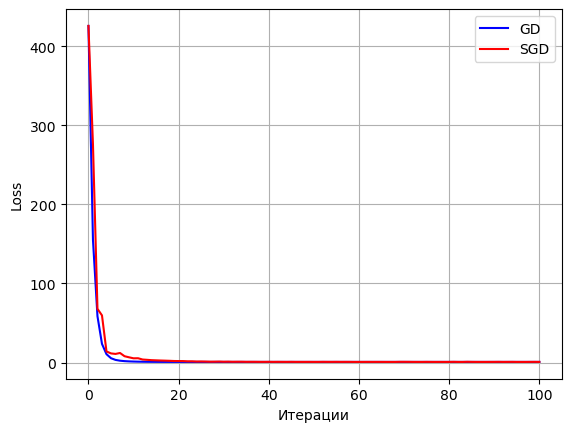

In [453]:
# -- YOUR CODE HERE -- ┌(ಠ_ಠ)┘
gd = gradient_descent(w_init, X, y, loss, 0.01, 100)
losses_gd = np.array([])
for i in gd:
    losses_gd = np.append(losses_gd, np.array(loss.calc_loss(X, y, i)))
sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.25, 100)
losses_sgd = np.array([])
for i in sgd:
    losses_sgd = np.append(losses_sgd, loss.calc_loss(X, y, i))
plt.plot(losses_gd, label='GD', color='blue')
plt.plot(losses_sgd, label='SGD', color='red')
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Именно по графику видно, что точность что стохастического, что обычного градиентного спуска приходят к 0 довольно быстро, но в sgd каждый шаг занимает в разы меньше времени (если в обычном считаем для 300 объектов, то в стохастическом для 10, то есть в 30 раз быстрее)

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`.

В методе `predict` мы будем применять нашу регрессию к датасету.

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`.

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [687]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        self.w = np.random.randint(low=-500, high=500, size=X.shape[1])
        self.w = gradient_descent(self.w, X, y, self.loss, self.lr, 100)[-1]
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [690]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [693]:
import pandas as pd

X_raw = pd.read_csv(
    "cars_data.csv",
    header=None,
    na_values=["?"],
    skiprows=1,
    index_col=0
)
X_raw = X_raw[~X_raw[26].isna()].reset_index(drop=True)
X_raw.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [695]:
y = X_raw[26]
X_raw = X_raw.drop(26, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [698]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [700]:
# -- YOUR CODE HERE -- =^･ω･^=
# создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

X_dum = pd.get_dummies(X_no_mis, drop_first=True, dtype=float)

# нормализуем
X_dum.columns = X_dum.columns.astype(str)
normalizer = MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)

# разбиваем данные на тест и трэйн
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [703]:
# -- YOUR CODE HERE -- (ﾉ´ з `)ノ
linear_regression.fit(x_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [706]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE -- ( ⚆ ω ⚆)
test_err = mean_squared_error(linear_regression.predict(x_train), y_train)
train_err = mean_squared_error(linear_regression.predict(x_test), y_test)
print(f'Ошибка на трейне - {test_err}\nОшибка на тесте - {train_err}')

Ошибка на трейне - 6289174.098814059
Ошибка на тесте - 7524029.170563826


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации.

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`.

Он должен вычислять лосс и градиент по формулам выше.

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`.

## 

In [743]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE -- (´｡• ᵕ •｡`)
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        return (1 / len(X)) * np.linalg.norm(X.dot(w) - y) **2 + self.coef * np.linalg.norm(w[:-1]) ** 2

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE -- (￢_￢)
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        w[-1] = 0
        return (2 / len(X)) * np.transpose(X).dot(X.dot(w) - y) + 2 * self.coef * w

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [746]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [749]:
# -- YOUR CODE HERE -- (＠_＠)
linear_regression2 = LinearRegression(MSEL2Loss(0.001))
linear_regression2.fit(x_train, y_train)
test_err = mean_squared_error(linear_regression2.predict(x_train), y_train)
train_err = mean_squared_error(linear_regression2.predict(x_test), y_test)
print(f'Ошибка на трейне - {test_err}\nОшибка на тесте - {train_err}')

Ошибка на трейне - 6367255.487856327
Ошибка на тесте - 7504646.077237014


В итоге вышло, что результат не улучшился вообще, причем если ставить большие по модулю лямбды, то ошибка вообще в космос улетает, при 1 уже десятки миллионов, при 400 inf, с отрицательными аналогично, лучше вссего оказалось держаться около нуля

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`.

Он должен вычислять лосс и градиент по формулам выше.

In [761]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE -- (っ˘ڡ˘ς)
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        z = np.abs(X.dot(w) - y)
        return (1 / len(X)) * np.where(z <= self.eps, 0.5 * z ** 2, self.eps * (z - 0.5 * self.eps))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE -- ٩(ˊ〇ˋ*)و
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        z = X.dot(w) - y
        return (1 / len(X)) * np.transpose(X).dot(np.where(np.abs(z) <= self.eps,z,self.eps * np.sign(z)))
        

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [818]:
# -- YOUR CODE HERE -- # (⌐■_■)
linear_regression3 = LinearRegression(HuberLoss(100410000))
linear_regression3.fit(x_train, y_train)
test_err = mean_squared_error(linear_regression3.predict(x_train), y_train)
train_err = mean_squared_error(linear_regression3.predict(x_test), y_test)
print(f'Ошибка на трейне - {test_err}\nОшибка на тесте - {train_err}')
# Да все равно мсе как будто лучше, ошибка не уменьшается :(

Ошибка на трейне - 8549693.888494484
Ошибка на тесте - 9452637.086075904


**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2025 в ячейку ниже:

# -- YOUR MEME HERE -- ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
Я нашел этот отрывок пару месяцев назад, так что будем считать, что мем 2025
https://youtu.be/F6bYFsixLO4?si=mKanzxPGNXKS-ecF

### БОНУС (2 балла)

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2 балла)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии.

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределения с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
# -- YOUR CODE HERE -- ʕ•ᴥ•ʔ